# Burrau-WorkPrecision

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-Burrau">
             Initial value problem: Burrau</a></li>

<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Work-Precision-diagrams-(Float64)">
             Work-Precision diagrams (Float64)</a></li> 

<li><a href="#Work-Precision-diagrams-(Float128)">
             Work-Precision diagrams (Float128)</a></li> 
             
             
<li><a href="#Save/Load-Data">
            Save/Load Data</a></li>  

</ul>  

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO
using RecursiveArrayTools
using IRKGaussLegendre


<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

4

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [4]:
using Hwloc
Hwloc.num_physical_cores()

8

<a href="#top">Back to the top</a>

## Initial value problem: Burrau

In [5]:
setprecision(BigFloat, 108);
include("../ODEProblems/Nbody.jl")
include("../ODEProblems/InitialBurrau.jl")

t0=0.0
t1=63.0 #very long


u064,Gm64 =InitialBurrau(Float64)
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64,Gm64);

u0128,Gm128=InitialBurrau(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128)

q064=u064[2,:,:]
v064=u064[1,:,:]
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64,Gm64);
prob2nd64 = SecondOrderODEProblem(NbodyODE2nd!,v064,q064,tspan64,Gm64);


q0128=u0128[2,:,:]
v0128=u0128[1,:,:]
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128);
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128,Gm128);


mysaveat=10
vsaveat=0.1
(typeof(u064),typeof(Gm64),typeof(tspan64),typeof(u0128),typeof(Gm128),typeof(tspan128))

(Array{Float64, 3}, Vector{Float64}, Tuple{Float64, Float64}, Array{BigFloat, 3}, Vector{BigFloat}, Tuple{BigFloat, BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [6]:
setprecision(BigFloat, 256)
#sol =solve(prob128,Vern9(),save_everystep=false, abstol=1e-32,reltol=1e-32);
#@save "./Data/burrau_test_sol.jld2" sol

@load "./Data/burrau_test_sol.jld2" sol
test_sol = TestSolution(sol)
sol.destats

u0256,Gm256=InitialBurrau(BigFloat)

E0=NbodyEnergy(u0256,Gm256)

(Float32(sol.t[end]),Float32(NbodyEnergy(sol.u[end],Gm256)/E0-1))

(63.0f0, 1.297102f-30)

In [7]:
ux=sol.u[end]
solx=ArrayPartition(ux[2,:,:],ux[1,:,:])
test_solx = TestSolution(tspan128,[solx]);

ux=sol.u[end]
solx2nd=ArrayPartition(ux[1,:,:],ux[2,:,:])
test_solx2nd = TestSolution(tspan128,[solx2nd]);

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float64)

In [8]:
abstols = 1.0 ./ 10.0 .^ (10:17)
reltols = 1.0 ./ 10.0 .^ (10:17);

### Second Order Problem: Vern9, IRKGL16

In [9]:
setups = [
          Dict(:alg=>Vern9())
          Dict(:alg=>IRKGL16(),:adaptive=>true)
]
solnames=["Vern9", "IRKGL16-adative"]
wp2 = WorkPrecisionSet(probdyn64,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=10,maxiters=10^9,names=solnames);

### SecondOrderProblem: DPRKN12

In [10]:
setups = [
          Dict(:alg=>DPRKN12())   
]
solnames=["DPRKN12"]
wp3 = WorkPrecisionSet(prob2nd64,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=10,maxiters=10^9,name=solnames);

### All methods in one Plot

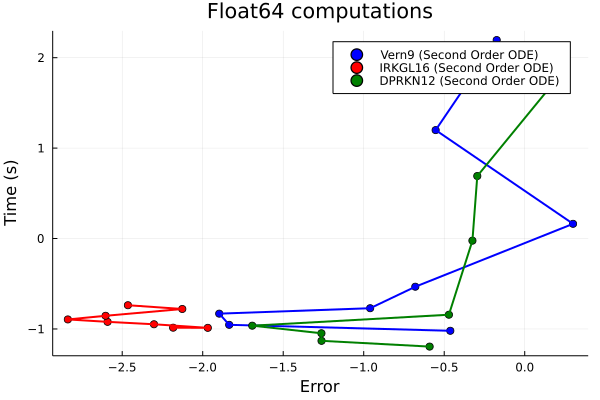

In [11]:
plot(title="Float64 computations",xlabel="Error", ylabel="Time (s)")
k=1
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="Vern9 (Second Order ODE)", color="blue")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="",lw=2, color="blue")
# 
k=2
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="IRKGL16 (Second Order ODE)",color="red")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="",lw=2,color="red")
#
k=1
plot!(log10.(wp3.wps[k].errors),log10.(wp3.wps[k].times), seriestype=:scatter, label="DPRKN12 (Second Order ODE)",color="green")
plot!(log10.(wp3.wps[k].errors),log10.(wp3.wps[k].times), label="", lw=2, color="green")

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float128)

In [12]:
setprecision(BigFloat, 108)
abstols = 1.0 ./ 10.0 .^ (12:30)
reltols = 1.0 ./ 10.0 .^ (12:30);

### Second Order ODE: Vern9, IRKGL16

In [ ]:
setups = [ Dict(:alg=>Vern9())
    
           Dict(:alg=>IRKGL16(mixed_precision=false),:adaptive=>true) 
           Dict(:alg=>IRKGL16(mixed_precision=true),:adaptive=>true)
           Dict(:alg=>IRKGL16(mixed_precision=true,threading=true),:adaptive=>true)

]
solnames = ["Vern9","IRKGL16-adap","IRKGL16-adap/mix", "IRKGL16-adap/mix/threads" ]
wp11 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=10,maxiters=10^9,name=solnames);

In [ ]:
plot(wp11)

### Second Order ODE: Vern9, IRKGL16  (mixed-precision=false)

In [ ]:
setups = [
          Dict(:alg=>Vern9())
          Dict(:alg=>IRKGL16(),:adaptive=>true) 
          Dict(:alg=>IRKGL16(threading=true),:adaptive=>true) 
]
solnames=["Vern9", "IRKGL16-adap", "IRKGL16-adap/thread"]
wp12 = WorkPrecisionSet(probdyn128,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=10,maxiters=10^9,names=solnames);

In [ ]:
plot(wp12)

### Second Order ODE: DPRKN12

In [ ]:
setups = [
          Dict(:alg=>DPRKN12())   
]
solnames=["DPRKN12"]
wp13 = WorkPrecisionSet(prob2nd128,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=10,maxiters=10^9,names=solnames);

In [ ]:
plot(wp13)

### Plot- Vern9:   General Ode vs Second Order ODE

In [ ]:
k=1
plot(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="Vern9 ( General ODE)")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="")
# 
k=1
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="Vern9 (Second Order ODE)")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="")


In [ ]:
k=2
plot(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16 (General ODE)", color="red")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="", color="red")
#
k=3
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16-MIX (General ODE)",  color="orange")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="",  color="orange")
#
k=4
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16-MIX-Thread(General ODE)",  color="blue")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="",  color="blue")
# 
k=2
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="IRKGL16 (Second Order ODE)",  color="green")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="", color="green")
# 
k=3
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="IRKGL16-Thread (Second Order ODE)",  color="black")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="", color="black")

In [ ]:
plot(title="Float128 computations", xlabel="Error", ylabel="Time (s)")
#k=1
#plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="Vern9 (DynamicProblem)",color="blue")
#plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="")
#
k=3
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16-MIX (OdeProblem)",color="red")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="",color="red")
#
k=1
plot!(log10.(wp13.wps[k].errors),log10.(wp13.wps[k].times), seriestype=:scatter, label="DPRKN12 (Second Order ODE)",color="green")
plot!(log10.(wp13.wps[k].errors),log10.(wp13.wps[k].times), label="",color="green")

<a href="#top">Back to the top</a>

### Save/Load Data

In [ ]:
# Float64 experiments
@save "./Data/output/OutBurrau_wp2.jld2" wp2
@save "./Data/output/OutBurrau_wp3.jld2" wp3
# Float128 experiments
@save "./Data/output/OutBurrau_wp11.jld2" wp11
@save "./Data/output/OutBurrau_wp12.jld2" wp12
@save "./Data/output/OutBurrau_wp13.jld2" wp13

In [ ]:
# Float64 experiments
#@load "./Data/output/OutBurrau_wp2.jld2" wp2
#@load "./Data/output/OutBurrau_wp3.jld2" wp3
# Float128 experiments
#@load "./Data/output/OutBurrau_wp11.jld2" wp11
#@load "./Data/output/OutBurrau_wp12.jld2" wp12
#@load "./Data/output/OutBurrau_wp13.jld2" wp13